In [57]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.spatial.distance import cdist
from scipy.special import gammaln, digamma
import itertools
from tqdm import tqdm

In [58]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
from model.velocity_only.base import *
from model.velocity_only import transition, preference, baseline
from model.helpers import compute_q, compute_sum_kl_div_dirichlet

from plot import plot

In [60]:
transition_velocity_tavv, transition_position_pvp = transition.build()
pref = preference.build()

# Pragmatic values: demonstrate that it works for one timestep

In [61]:
v_idx = 2
pos_idx = 11
t_idx = 5

qv = np.zeros(n_velocity)
qv[v_idx] = 1.
qp = np.zeros(n_position)
qp[pos_idx] = 1.

qvs = np.zeros((n_action, n_velocity))
qps = np.zeros((n_action, n_position))
for action_idx, a in enumerate(range(n_action)):

    qv_new = qv @ transition_velocity_tavv[t_idx, a, :, :]
    qp_new = qp @ (qv_new @ transition_position_pvp)
    qvs[action_idx] = qv_new
    qps[action_idx] = qp_new

pragmatic = np.sum(qps * pref, axis=1)
print("pragmatic values", pragmatic)

e_v = np.zeros(2)
for i in range(2):
    e_v[i] = np.average(velocity, weights=transition_velocity_tavv[t_idx, i, v_idx, :])
print("expected velocities", e_v)

pragmatic values [-5.13292073 -4.96458829]
expected velocities [0.0477193  0.32070175]


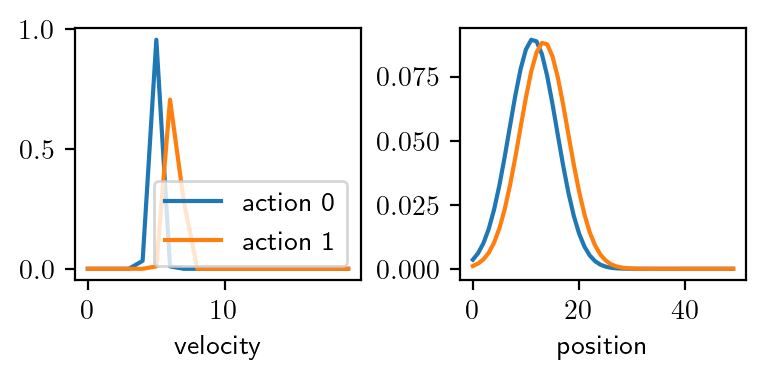

In [62]:
fig, axes = plt.subplots(figsize=(4, 2), ncols=2)

ax = axes[0]
for action_idx, a in enumerate(range(n_action)):
    ax.plot(qvs[action_idx], label=f"action {a}")

ax.set_xlabel("velocity")
ax.legend(loc="lower right")

ax = axes[1]
for action_idx, a in enumerate(range(n_action)):
    ax.plot(qps[action_idx], label=f"action {a}")

ax.set_xlabel("position")
plt.tight_layout()

# Pragmatic values: demonstrate that it works for a run

In [63]:
horizon = 6
n_sample_run = 10

# For logs
hist_pos, hist_vel = np.zeros((n_sample_run, n_timestep)), np.zeros((n_sample_run, n_timestep))

# For each sample...
for sample in range(n_sample_run):

    pos_idx = np.absolute(position).argmin()  # Something close to 0
    v_idx = np.absolute(velocity).argmin() # Something close to 0

    np.random.seed(123 + sample*123)

    for t_idx in range(n_timestep):

        h = min(horizon, n_timestep - t_idx)
        action_plan = list(itertools.product(range(n_action), repeat=h))

        pragmatic = np.zeros(len(action_plan))
        for ap_index, ap in enumerate(action_plan):

            qvs = np.zeros((h, n_velocity))
            qps = np.zeros((h, n_position))

            qv = np.zeros(n_velocity)
            qv[v_idx] = 1.
            qp = np.zeros(n_position)
            qp[pos_idx] = 1.

            for h_idx in range(h):
                a = ap[h_idx]
                rollout_t_index = t_idx + h_idx
                qv = qv @ transition_velocity_tavv[rollout_t_index, a, :, :]
                qp = qp @ (qv @ transition_position_pvp)
                qvs[h_idx] = qv
                qps[h_idx] = qp

            pragmatic[ap_index] = np.sum(qps @ pref)

        a = action_plan[np.argmax(pragmatic)][0]

        v_idx = np.random.choice(np.arange(n_velocity), p=transition_velocity_tavv[t_idx, a, v_idx, :])
        pos_idx = np.random.choice(np.arange(n_position), p=transition_position_pvp[pos_idx, v_idx, :])

        hist_pos[sample, t_idx] = position[pos_idx]
        hist_vel[sample, t_idx] = velocity[v_idx]

run = {
    "policy": "af-pragmatic", 
    "position": hist_pos, 
    "velocity": hist_vel
}

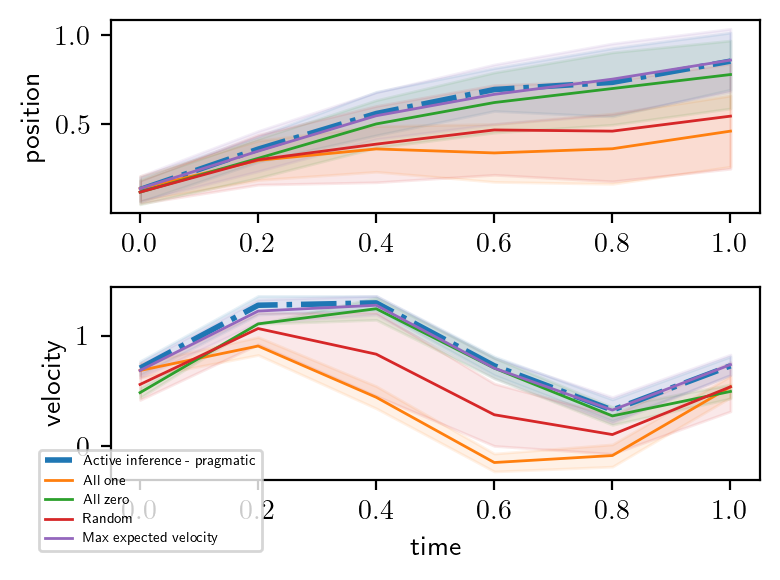

In [66]:
baselines = baseline.run(
    transition_velocity_tavv=transition_velocity_tavv, 
    transition_position_pvp=transition_position_pvp)
plot.runs(run, *baselines)

# Epistemic value

### Learning the model (= inferring the transition) using a RANDOM policy

In [75]:
all_hist_err = {}
policies_err = []

In [134]:
n_episode = 200
n_sample_run = 20
hist_err = np.zeros((n_sample_run, n_episode*n_timestep))

for sample in range(n_sample_run):

    alpha_tavv = np.zeros((n_timestep, n_action, n_velocity, n_velocity)) + np.finfo(np.float64).eps

    if sample == 0:
        error = np.sum(np.absolute(transition_velocity_tavv - compute_q(alpha_tavv)))
        print(f"Initial error {error:.2f}")

    epoch = 0
    for ep_idx in range(n_episode):

        np.random.seed(12334 + ep_idx + sample * 123)

        pos_idx = np.absolute(position).argmin()  # Something close to 0
        v_idx = np.absolute(velocity).argmin() # Something close to 0

        action_plan = np.random.randint(n_action, size=n_timestep)

        for t_idx, t in enumerate(timestep):

            # Pick new action and draw new velocity
            a = action_plan[t_idx]
            new_v_index = np.random.choice(
                np.arange(n_velocity), 
                p=transition_velocity_tavv[t_idx, a, v_idx, :])

            # Update alpha
            # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
            alpha_tavv[t_idx, a, v_idx, new_v_index] += 1

            # Update velocity and position
            v_idx = new_v_index
            pos_idx = np.random.choice(np.arange(n_position), p=transition_position_pvp[pos_idx, v_idx, :])

            # Log
            error = np.sum(np.absolute(transition_velocity_tavv - compute_q(alpha_tavv)))
            hist_err[sample, epoch] = error
            epoch += 1

    print(f"[Sample {sample}] Error after {epoch} epochs {error:.2f}")

run_random = {"policy": "random", "error": hist_err}

Initial error 428.27
[Sample 0] Error after 1200 epochs 351.70
[Sample 1] Error after 1200 epochs 346.87
[Sample 2] Error after 1200 epochs 350.88
[Sample 3] Error after 1200 epochs 347.50
[Sample 4] Error after 1200 epochs 345.02
[Sample 5] Error after 1200 epochs 347.86
[Sample 6] Error after 1200 epochs 347.91
[Sample 7] Error after 1200 epochs 343.52
[Sample 8] Error after 1200 epochs 342.83
[Sample 9] Error after 1200 epochs 344.52
[Sample 10] Error after 1200 epochs 346.45
[Sample 11] Error after 1200 epochs 346.72
[Sample 12] Error after 1200 epochs 347.36
[Sample 13] Error after 1200 epochs 346.86
[Sample 14] Error after 1200 epochs 351.07
[Sample 15] Error after 1200 epochs 351.51
[Sample 16] Error after 1200 epochs 352.00
[Sample 17] Error after 1200 epochs 349.28
[Sample 18] Error after 1200 epochs 348.44
[Sample 19] Error after 1200 epochs 350.59


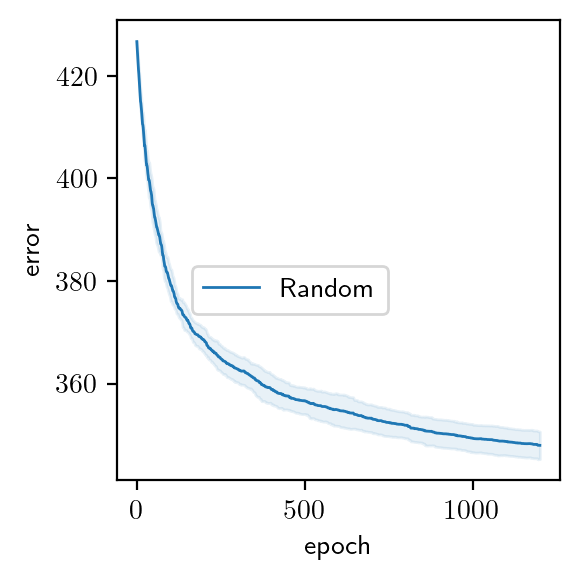

In [135]:
plot.error(run_random)

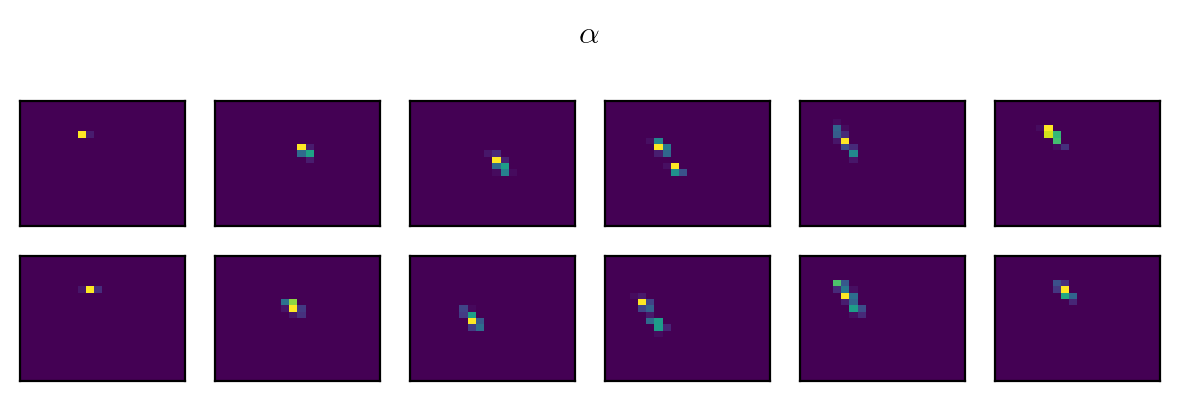

In [136]:
plot.q(alpha_tavv, title=r"$\alpha$")

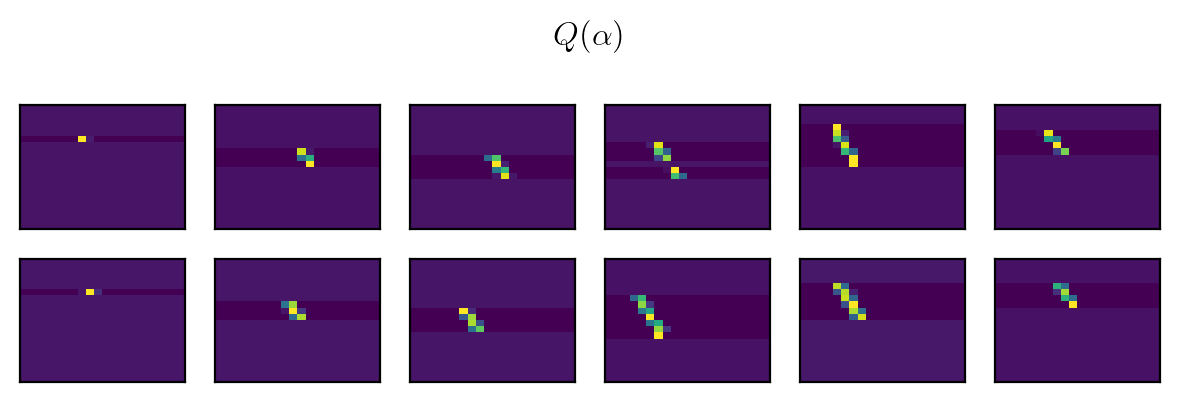

In [137]:
q = compute_q(alpha_tavv)
plot.q(q, title=r"$Q(\alpha)$")

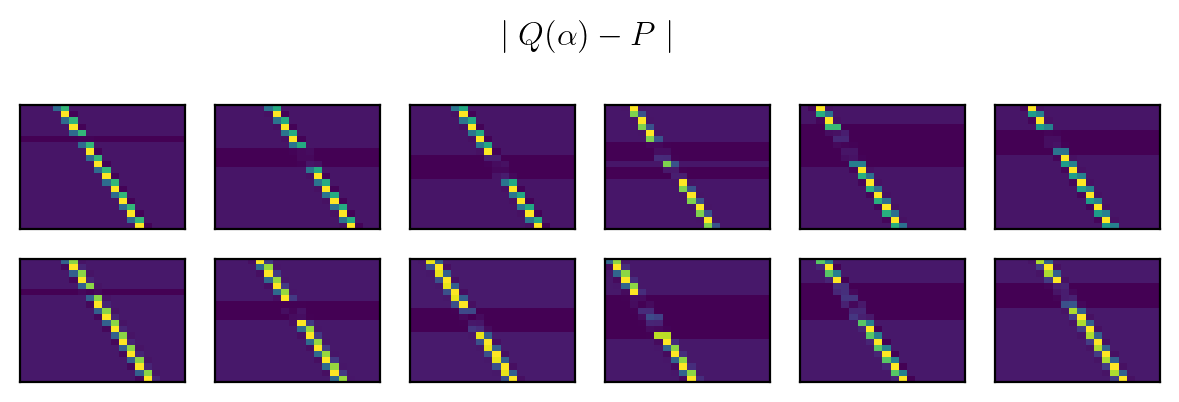

In [138]:
q = compute_q(alpha_tavv)
diff = np.absolute(transition_velocity_tavv - q)
plot.q(diff, title=r"$\mid Q(\alpha) - P \mid$")

In [146]:
n_episode = 200
n_sample_run = 20
horizon = len(timestep)
hist_err = np.zeros((n_sample_run, n_episode*n_timestep))

for sample in range(n_sample_run):

    # Initialize alpha
    alpha_tavv = np.zeros((n_timestep, n_action, n_velocity, n_velocity)) + np.finfo(np.float64).eps

    # Log error
    error = np.sum(np.absolute(transition_velocity_tavv - compute_q(alpha_tavv)))
    if sample == 0:
        print(f"Initial error {error:.2f}")

    hist_a = []
    epoch = 0

    # with tqdm(total=n_episode) as pbar:
    for ep_idx in range(n_episode):

        np.random.seed(12334 + ep_idx + sample * 123)

        pos_idx = np.absolute(position).argmin()  # Something close to 0
        v_idx = np.absolute(velocity).argmin()    # Something close to 0

        for t_idx, t in enumerate(timestep):

            h = min(horizon, n_timestep - t_idx)
            action_plan = list(itertools.product(range(n_action), repeat=h))

            # Initialize action plan values
            pragmatic = np.zeros(len(action_plan))
            epistemic = np.zeros(len(action_plan))

            qt = compute_q(alpha_tavv)

            # Compute value of each action plan
            for ap_index, ap in enumerate(action_plan):

                qvs = np.zeros((h, n_velocity))
                qps = np.zeros((h, n_position))
    
                qv = np.zeros(n_velocity)
                qv[v_idx] = 1.
                qp = np.zeros(n_position)
                qp[pos_idx] = 1.
    
                for h_idx in range(h):
                    previous_qv = qv.copy()
                    
                    a = ap[h_idx]
                    rollout_t_index = t_idx + h_idx
                    qv = qv @ transition_velocity_tavv[rollout_t_index, a, :, :]
                    qp = qp @ (qv @ transition_position_pvp)
                    
                    # Equation B.34 (p 253) 
                    _qt = qt[rollout_t_index, a]
                    make_sense = _qt > 0
                    _qt += 1e-16
                    w = 1/(2*_qt) - 1/(2*np.sum(_qt, axis=0))
                    w = w * make_sense.astype(float)
                    epistemic[ap_index] -= (previous_qv@w)@qv
                    
                    # Eq B.29 (second term is 0 because the entropy of the likelihood matrices is 0)
                    epistemic[ap_index] -= qp @ np.log(qp + 1e-16)
                    epistemic[ap_index] -= qv @ np.log(qv + 1e-16)
                    
                    qvs[h_idx] = qv
                    qps[h_idx] = qp
                
                # Eq B.28
                pragmatic[ap_index] = np.sum(qps @ pref)

                
               # # Initialize the rollout model (= counts)
               #  alpha_tavv_rollout = alpha_tavv.copy()
               # 
               #  qv = np.zeros(n_velocity)
               #  qv[v_idx] = 1.
               # 
               #  for h_idx, a in enumerate(ap):
               # 
               #      # Update rollout time index
               #      rollout_t_index = t_idx + h_idx
               # 
               #      # Update beliefs about the transition model
               #      alpha_tavv_rollout[rollout_t_index,  a, :, :] += \
               #          qv[:, np.newaxis] * q[rollout_t_index, a, :, :]
               # 
               #      # Update beliefs about the velocity and position 
               #      # [IMPORTANT] => do it after updating beliefs about the transitions
               #      qv = qv @ q[rollout_t_index, a, :, :]
               #     
               #  epistemic[ap_index] = compute_sum_kl_div_dirichlet(alpha_rollout=alpha_tavv_rollout, alpha=alpha_tavv)
                # print(f"t={t_idx}, ap={ap_index}, v={epistemic[ap_index]}")
                
                
            # Choose the best action plan
            best_action_plan_index = np.random.choice(np.arange(len(action_plan))[epistemic == epistemic.max()])
            a = action_plan[best_action_plan_index][0]

            new_v_index = np.random.choice(n_velocity, p=transition_velocity_tavv[t_idx, a, v_idx, :])

            # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
            alpha_tavv[t_idx, a, v_idx, new_v_index] += 1

            # Update velocity and position
            v_idx = new_v_index
            pos_idx = np.random.choice(n_position, p=transition_position_pvp[pos_idx, v_idx, :])

            # Log
            error = np.sum(np.absolute(transition_velocity_tavv - compute_q(alpha_tavv)))
            hist_err[sample, epoch] = error
            hist_a.append(a)
            epoch += 1

            # pbar.set_postfix(error=f"{error:.2f}")
            # pbar.update(1)

    print(f"[Sample {sample}] Error after {epoch} epochs: {error:.2f}")

    print(f"[Sample {sample}] Freq choose action 0: {100*hist_a.count(0)/len(hist_a):.2f}%")

run_af_epistemic = {"policy": "af-epistemic", "error": hist_err}

Initial error 428.27
[Sample 0] Error after 1200 epochs: 345.91
[Sample 0] Freq choose action 0: 50.58%
[Sample 1] Error after 1200 epochs: 348.80
[Sample 1] Freq choose action 0: 49.50%
[Sample 2] Error after 1200 epochs: 347.33
[Sample 2] Freq choose action 0: 49.08%
[Sample 3] Error after 1200 epochs: 348.11
[Sample 3] Freq choose action 0: 50.83%
[Sample 4] Error after 1200 epochs: 351.50
[Sample 4] Freq choose action 0: 53.92%


KeyboardInterrupt: 

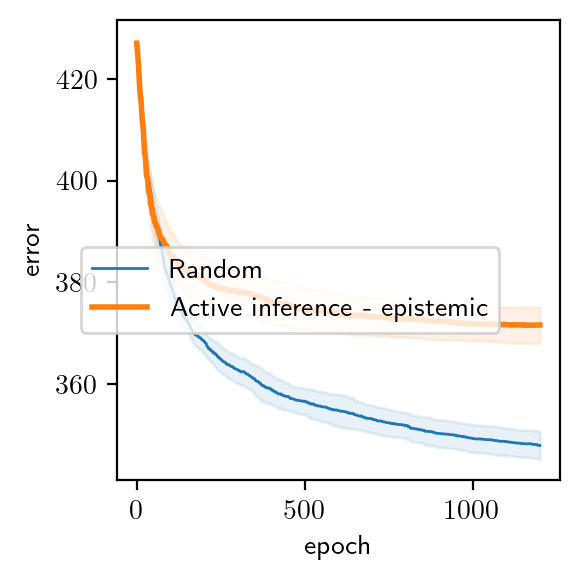

In [145]:
plot.error(run_random, run_af_epistemic)

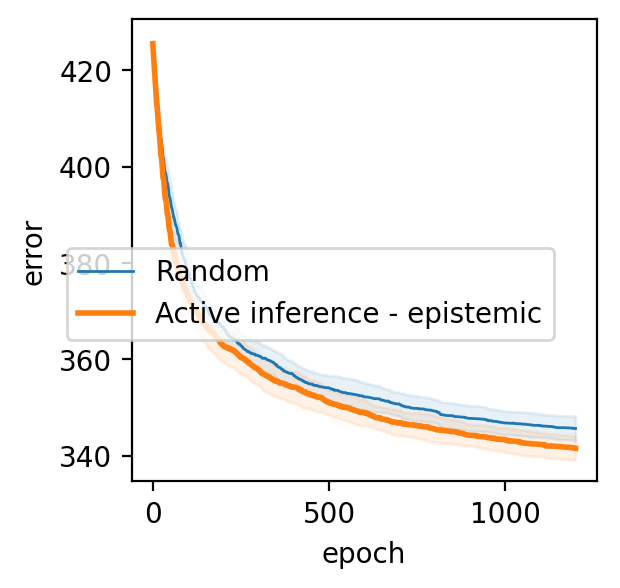

In [35]:
fig, ax = plt.subplots(figsize=(3, 3))
for i, policy in enumerate(policies_err):
    label = policy.replace("-", " ").capitalize()
    hist_err_mean = all_hist_err[policy].mean(axis=0)
    x = np.arange(len(hist_err_mean))
    hist_err_std = all_hist_err[policy].std(axis=0)

    if label.startswith("Af"):
        label = label.replace("Af", "Active inference -")
        linestyle, linewidth = "-", 2
    else:
        linestyle, linewidth = "-", 1
    ax.plot(x, hist_err_mean, color=f"C{i}", label=label, linestyle=linestyle, linewidth=linewidth)
    ax.fill_between(x, hist_err_mean - hist_err_std, hist_err_mean + hist_err_std, alpha=0.1, color=f"C{i}")
    ax.set_ylabel("error")
    ax.set_xlabel("epoch")

fig.legend(loc="center");

# All together

In [37]:
n_episode = 400
n_sample_run = 20
hist_err = np.zeros((n_sample_run, n_episode*n_timestep))
hist_pos = np.zeros((n_sample_run, n_episode, n_timestep))
hist_vel = np.zeros((n_sample_run, n_episode, n_timestep))

for sample in range(n_sample_run):

    alpha_tavv = np.zeros((n_timestep, n_action, n_velocity, n_velocity)) + np.finfo(np.float64).tiny + 0.01

    error = np.sum(np.absolute(transition_velocity_tavv - q_transition_velocity(alpha_tavv)))
    if sample == 0:
        print(f"Initial error {error:.2f}")

    hist_a = []
    epoch = 0

    with tqdm(total=n_episode) as pbar:
        for ep_idx in range(n_episode):

            np.random.seed(12334 + ep_idx + sample * 123)

            pos_idx = np.absolute(position).argmin()  # Something close to 0
            v_idx = np.absolute(velocity).argmin() # Something close to 0

            for t_idx, t in enumerate(timestep):

                h = min(horizon, n_timestep - t_idx)
                action_plan = list(itertools.product(range(n_action), repeat=h))
                n_action_plan = len(action_plan)

                # Initialize action plan values
                pragmatic = np.zeros(n_action_plan)
                epistemic = np.zeros(n_action_plan)

                q = q_transition_velocity(alpha_tavv)

                # Compute value of each action plan
                for ap_index, ap in enumerate(action_plan):

                    # Initialize the rollout model
                    alpha_tavv_rollout = alpha_tavv.copy()
                    qv = np.zeros(n_velocity)
                    qv[v_idx] = 1.
                    qps = np.zeros((h, n_position))
                    qp = np.zeros(n_position)
                    qp[pos_idx] = 1.

                    for h_idx, a in enumerate(ap):

                        # Update rollout time index
                        rollout_t_index = t_idx + h_idx

                        # Update beliefs about the transition model
                        alpha_tavv_rollout[rollout_t_index,  a, :, :] += qv[:, np.newaxis] * q[rollout_t_index, a, :, :]

                        # Update beliefs about the velocity and position [IMPORTANT: doing this after updating the transition model]
                        qv = qv @ q[rollout_t_index, a, :, :]
                        qp = qp @ (qv @ transition_position_pvp)
                        qps[h_idx] = qp

                    # Compute the pragmatic value of the action plan
                    pragmatic[ap_index] = np.sum(qps @ log_prior)

                    # Compute sum of the KL divergence between the model after the rollout and the current model
                    epistemic[ap_index] = compute_sum_kl_div_dirichlet(alpha_rollout=alpha_tavv_rollout, alpha=alpha_tavv)

                val = pragmatic + epistemic
                best_action_plan_indexes = np.arange(n_action_plan)[val == val.max()]
                selected_action_plan_idx = np.random.choice(best_action_plan_indexes)
                a = action_plan[selected_action_plan_idx][0]

                new_v_index = np.random.choice(n_velocity, p=transition_velocity_tavv[t_idx, a, v_idx, :])

                # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
                alpha_tavv[t_idx, a, v_idx, new_v_index] += 1

                # Update velocity and position
                v_idx = new_v_index
                pos_idx = np.random.choice(n_position, p=transition_position_pvp[pos_idx, v_idx, :])

                # Log
                error = np.sum(np.absolute(transition_velocity_tavv - q_transition_velocity(alpha_tavv)))
                hist_err[sample, epoch] = error
                hist_pos[sample, ep_idx, t_idx] = position[pos_idx]
                hist_vel[sample, ep_idx, t_idx] = velocity[v_idx]
                hist_a.append(a)
                epoch += 1

            pbar.set_description(f"[Sample {sample}] [Episode {ep_idx}]")
            pbar.set_postfix(error=f"{error:.2f}", position=f"{position[pos_idx]:.2f}")
            pbar.update(1)

        print(f"[Sample {sample}] Error after {epoch} epochs: {error:.2f}")
        print(f"[Sample {sample}] Freq choose action 0: {100*hist_a.count(0)/len(hist_a):.2f}%")

policy = "af"
if policy not in policies:
    policies.append(policy)
if policy not in policies_err:
    policies_err.append(policy)
all_hist_err[policy] = hist_err
all_hist_pos[policy] = hist_pos[:, -1, :] # Keep only the last episode
all_hist_vel[policy] = hist_vel[:, -1, :] # Keep only the last episode

Initial error 426.67


[Sample 0] [Episode 399]: 100%|██████████| 400/400 [00:13<00:00, 28.82it/s, error=347.39, position=0.49]


[Sample 0] Error after 2400 epochs: 347.39
[Sample 0] Freq choose action 0: 52.58%


[Sample 1] [Episode 399]: 100%|██████████| 400/400 [00:14<00:00, 28.52it/s, error=345.69, position=1.06]


[Sample 1] Error after 2400 epochs: 345.69
[Sample 1] Freq choose action 0: 53.12%


[Sample 2] [Episode 399]: 100%|██████████| 400/400 [00:13<00:00, 28.60it/s, error=348.53, position=0.83]


[Sample 2] Error after 2400 epochs: 348.53
[Sample 2] Freq choose action 0: 52.42%


[Sample 3] [Episode 399]: 100%|██████████| 400/400 [00:13<00:00, 28.59it/s, error=349.53, position=1.03]


[Sample 3] Error after 2400 epochs: 349.53
[Sample 3] Freq choose action 0: 52.12%


[Sample 4] [Episode 399]: 100%|██████████| 400/400 [00:14<00:00, 28.38it/s, error=345.15, position=0.63]


[Sample 4] Error after 2400 epochs: 345.15
[Sample 4] Freq choose action 0: 52.46%


[Sample 5] [Episode 399]: 100%|██████████| 400/400 [00:14<00:00, 28.50it/s, error=344.35, position=0.92]


[Sample 5] Error after 2400 epochs: 344.35
[Sample 5] Freq choose action 0: 52.83%


[Sample 6] [Episode 399]: 100%|██████████| 400/400 [00:14<00:00, 27.87it/s, error=344.39, position=0.65]


[Sample 6] Error after 2400 epochs: 344.39
[Sample 6] Freq choose action 0: 52.50%


[Sample 7] [Episode 399]: 100%|██████████| 400/400 [00:14<00:00, 26.97it/s, error=356.44, position=0.65]


[Sample 7] Error after 2400 epochs: 356.44
[Sample 7] Freq choose action 0: 52.42%


[Sample 8] [Episode 399]: 100%|██████████| 400/400 [00:15<00:00, 25.93it/s, error=351.67, position=0.36]


[Sample 8] Error after 2400 epochs: 351.67
[Sample 8] Freq choose action 0: 52.58%


[Sample 9] [Episode 399]: 100%|██████████| 400/400 [00:15<00:00, 26.02it/s, error=351.61, position=0.81]


[Sample 9] Error after 2400 epochs: 351.61
[Sample 9] Freq choose action 0: 52.21%


[Sample 10] [Episode 399]: 100%|██████████| 400/400 [00:15<00:00, 26.05it/s, error=347.30, position=0.72]


[Sample 10] Error after 2400 epochs: 347.30
[Sample 10] Freq choose action 0: 52.50%


[Sample 11] [Episode 399]: 100%|██████████| 400/400 [00:14<00:00, 27.16it/s, error=352.99, position=0.74]


[Sample 11] Error after 2400 epochs: 352.99
[Sample 11] Freq choose action 0: 52.50%


[Sample 12] [Episode 399]: 100%|██████████| 400/400 [00:14<00:00, 27.10it/s, error=341.24, position=1.08]


[Sample 12] Error after 2400 epochs: 341.24
[Sample 12] Freq choose action 0: 52.67%


[Sample 13] [Episode 399]: 100%|██████████| 400/400 [00:14<00:00, 26.75it/s, error=346.98, position=0.79]


[Sample 13] Error after 2400 epochs: 346.98
[Sample 13] Freq choose action 0: 51.83%


[Sample 14] [Episode 399]: 100%|██████████| 400/400 [00:15<00:00, 26.26it/s, error=352.16, position=1.06]


[Sample 14] Error after 2400 epochs: 352.16
[Sample 14] Freq choose action 0: 52.42%


[Sample 15] [Episode 399]: 100%|██████████| 400/400 [00:15<00:00, 26.20it/s, error=350.67, position=1.06]


[Sample 15] Error after 2400 epochs: 350.67
[Sample 15] Freq choose action 0: 52.08%


[Sample 16] [Episode 399]: 100%|██████████| 400/400 [00:14<00:00, 27.37it/s, error=349.68, position=0.72]


[Sample 16] Error after 2400 epochs: 349.68
[Sample 16] Freq choose action 0: 52.21%


[Sample 17] [Episode 399]: 100%|██████████| 400/400 [00:14<00:00, 26.75it/s, error=349.73, position=1.08]


[Sample 17] Error after 2400 epochs: 349.73
[Sample 17] Freq choose action 0: 52.58%


[Sample 18] [Episode 399]: 100%|██████████| 400/400 [00:15<00:00, 26.64it/s, error=348.25, position=0.88]


[Sample 18] Error after 2400 epochs: 348.25
[Sample 18] Freq choose action 0: 52.92%


[Sample 19] [Episode 399]: 100%|██████████| 400/400 [00:14<00:00, 26.93it/s, error=347.95, position=1.03]

[Sample 19] Error after 2400 epochs: 347.95
[Sample 19] Freq choose action 0: 52.46%


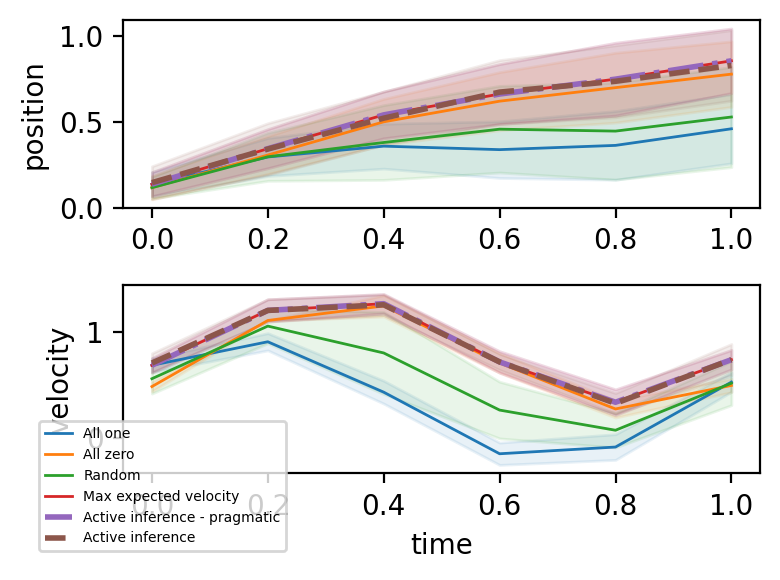

In [46]:
plot_runs(policies, all_hist_pos, all_hist_vel)

# Possible extensions

    - Always using a fix horizon (modulo the beginning of the episode)
    - Pretraining the model
    - Using a couple of different generative models
    - Add meaninful priors (e.g. night)
    - Add the current position as a predictor of the velocity

In [ ]:
    # # ---- Pre-training ----
    #
    # epoch = 0
    # for idx_ep in tqdm(range(n_episode_pre_train)):
    #
    #     np.random.seed(12334 + idx_ep)
    #
    #     pos_idx = np.absolute(position).argmin()  # Something close to 0
    #     v_idx = np.absolute(velocity).argmin() # Something close to 0
    #
    #     action_plan = np.random.randint(n_action, size=n_timestep)
    #
    #     for ap_index in range(len(action_plan)):
    #
    #         a = action_plan[t_idx]
    #         new_v_index = np.random.choice(np.arange(n_velocity), p=transition_velocity_tvav[t_idx, v_idx, a, :])
    #
    #         # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
    #         alpha_tvav[t_idx, v_idx, a, new_v_index] += 1
    #
    #         # print("v_idx", v_idx, "new_v_index", new_v_index)
    #
    #         # Update velocity and position
    #         v_idx = new_v_index
    #         pos_idx = np.random.choice(np.arange(n_position), p=transition_position_pvp[pos_idx, v_idx, :])
    #
    #         # Log
    #         error = np.sum(np.absolute(transition_velocity_tvav - q_transition_velocity(alpha_tvav)))
    #         hist_err.append(error)
    #         epoch += 1

    # print(f"Error after {epoch} epochs, before learning: {error}")